<a href="https://colab.research.google.com/github/Mufabo/ICASSP20.T6.R/blob/master/ICASSP20_T6_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

In [ ]:
# Only for colab
!sudo apt install libgsl-dev
!pip install rpy2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgsl-dev is already the newest version (2.4+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [ ]:
%reload_ext rpy2.ipython
%config IPCompleter.greedy=True
%config InlineBackend.figure_format = 'retina'

In [ ]:
%%R
# Takes 15 minutes
install.packages("devtools")
devtools::install_github("Mufabo/ICASSP20.T6.R")

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/devtools_2.3.2.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 373387 bytes (364 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wri

# SI_BIC

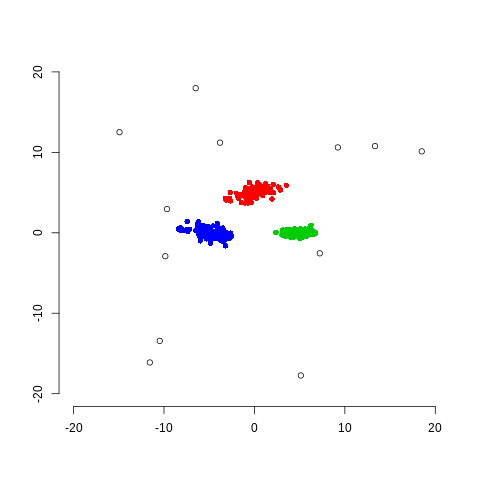

In [ ]:
%%R
library(ICASSP20.T6.R)

# User Input

MC <- 5 # number of Monte Carlo iterations
epsilon <- 0.04 # percantage of replacement outliers
N_k <- 100 # Number of samples per cluster

em_bic <- matrix(c(1,1, 2,2, 2,4, 3,3, 3,4),5, 2, byrow = TRUE)
embic_iter = nrow(em_bic)
nu <- 3 # t
qH <- 0.8 # Huber
cT <- 4.685 # Tukey

tmp <- data_31(N_k, epsilon)
data <- tmp$data
labels_true <- tmp$labels
r <- tmp$r
N <- tmp$N
K_true <- tmp$K_true
mu_true <- tmp$mu_true
S_true <- tmp$S_true
L_max <- 2 * K_true # search range

# Huber Parameters

cH <- sqrt(stats::qchisq(qH, r))
bH <- stats::pchisq(cH^2, r+2) + cH^2/r*(1-stats::pchisq(cH^2, r))
aH <- gamma(r/2)/pi^(r/2) / ( (2*bH)^(r/2)*(gamma(r/2) - pracma::incgam(r/2, cH^2/(2*bH))) + (2*bH*cH^2*exp(-cH^2/(2*bH)))/(cH^2 - bH * r))

# Functional Parameters

g <- list(gaus = function(t) g_gaus(t, r),
        t = function(t) g_t(t, r, nu),
      huber = function(t) g_huber(t, r, list(cH, bH, aH)))

rho <- list(gaus = function(t) rho_gaus(t, r),
        t = function(t) rho_t(t, r, nu),
        huber = function(t) rho_huber(t, r, list(cH, bH, aH)),
        tukey = function(t) rho_tukey(t, r, cT)
        )

psi <- list(gaus = function(t) psi_gaus(t),
        t = function(t) psi_t(t, r, nu),
        huber = function(t) psi_huber(t, r, list(cH, bH)),
        tukey = function(t) psi_tukey(t, cT)
        )

eta <- list(gaus = function(t) eta_gaus(t),
        t = function(t) eta_t(t, r, nu),
        huber = function(t) eta_huber(t, r, list(cH, bH)),
        tukey = function(t) eta_tukey(t, cT)
        )

# Cluster Enumeration

bic <- array(0, c(MC, L_max, 3, embic_iter))
like <- array(0, c(MC, L_max, 3, embic_iter))
pen <- array(0, c(MC, L_max, 3, embic_iter))

oldw <- getOption("warn")
options(warn = -1)

for(iMC in 1:MC){
for(ii_embic in 1:embic_iter){
for(ll in 1:L_max){
 sprintf('iMc: %i, ii_embic: %i, ll: %i', iMC, ii_embic, ll)

 # EM
 tmp <- EM_RES(data, ll, g[[em_bic[ii_embic, 1]]], psi[[em_bic[ii_embic, 1]]])
 
 mu_est <- tmp$mu_hat
 S_est <- tmp$S_hat
 t <- tmp$t
 R <- tmp$R
 mem <- (R == apply(R, 1, max))
 
 # BIC
 bicf <- BIC_F(data, S_est, mu_est, t, mem, rho[[em_bic[ii_embic, 2]]], psi[[em_bic[ii_embic, 2]]], eta[[em_bic[ii_embic, 2]]])
 bica <- BIC_A(S_est, t, mem, rho[[em_bic[ii_embic, 2]]], psi[[em_bic[ii_embic, 2]]], eta[[em_bic[ii_embic, 2]]])
 bics <- BIC_S(S_est, t, mem, rho[[em_bic[ii_embic, 2]]])
 
 bic[iMC, ll, , ii_embic] <- c(bicf$bic, bica$bic, bics$bic)
 like[iMC, ll, , ii_embic] <- c(bicf$like, bica$like, bics$like)
 pen[iMC, ll, , ii_embic] <- c(bicf$pen, bica$pen, bics$pen)
}
} 
}

options(warn = oldw)

# Averaging over MC

bic_avg <- rowMeans(aperm(bic, c(2,3,4,1)), dims=3)
pen_avg <- rowMeans(aperm(pen, c(2,3,4,1)), dims=3)
like_avg <- rowMeans(aperm(like, c(2,3,4,1)), dims=3)

# Plots

ICASSP20.T6.R::plot_scatter(cbind(labels_true, data), K_true, r)

marker = c('o','s','d','*','x','^','v','>','<','p','h', '+','o')
names = c("Finite", "Asymptotic", "Schwarz")
g_names = c("Gaus", "t", "Huber", "Tukey")


The graph above shows the three true clusters in color and the outliers as hollow circles.

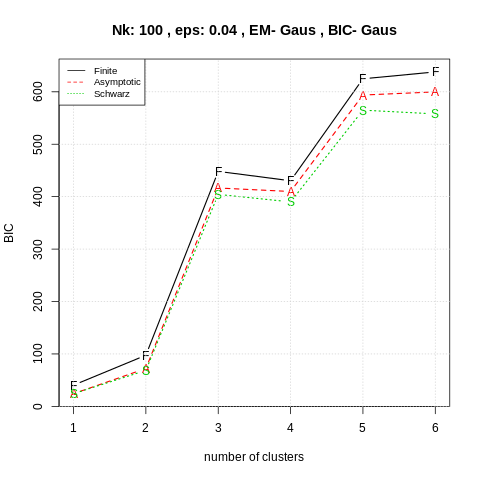

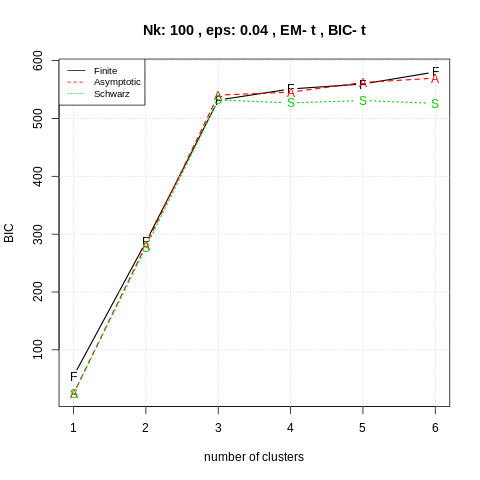

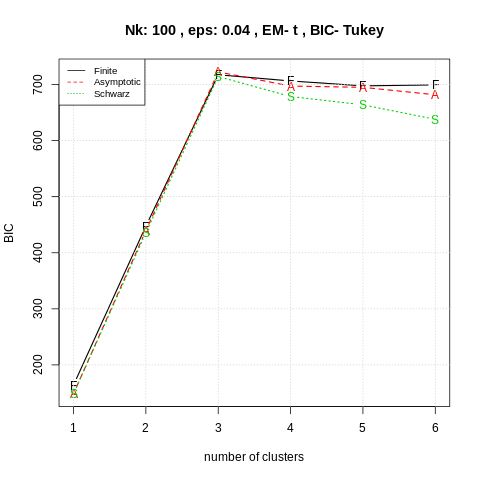

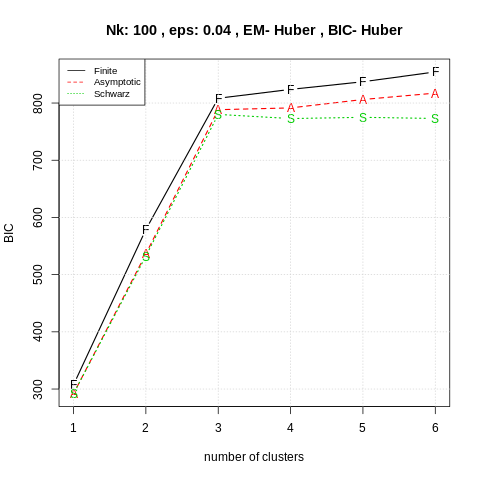

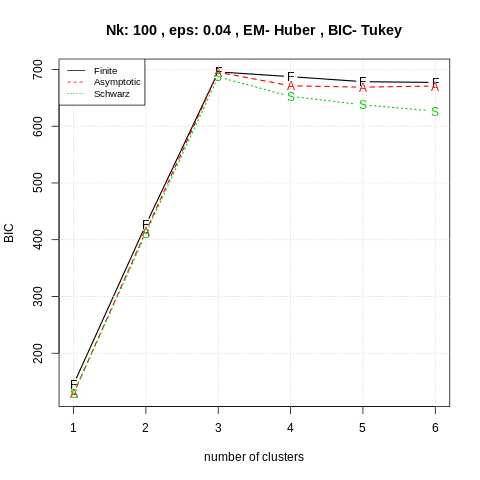

In [ ]:
%%R
# BIC 

for(ii_embic in 1:embic_iter){
graphics::matplot(bic_avg[,,ii_embic], lwd = 1.5, xlab = "number of clusters", ylab = "BIC", pch=c("F", "A", "S"), type = 'b', col=1:3)
graphics::title(paste("Nk:",toString(N_k),", eps:", toString(epsilon),", EM-", g_names[em_bic[ii_embic,1]], ", BIC-", g_names[em_bic[ii_embic,2]]))


graphics::grid()
graphics::legend("topleft", legend=names, lty=1:3, cex=0.8, col=1:3)

}

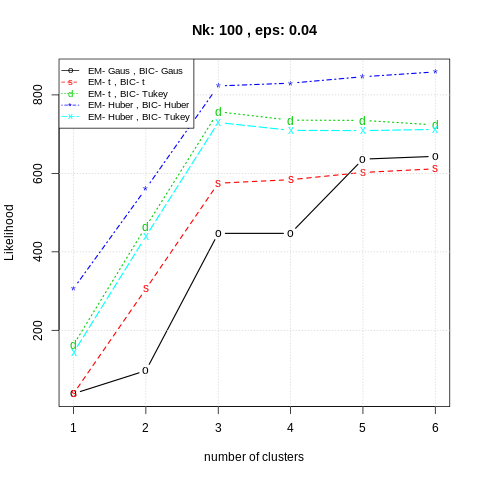

In [ ]:
%%R
# Likelihood

graphics::matplot(like_avg[,1,], lwd = 1.5, xlab = "number of clusters", ylab = "Likelihood", pch=marker[1:5], type = 'b', col=1:5)
graphics::title(paste("Nk:",toString(N_k),", eps:", toString(epsilon)))


leg_names = c()
for (i in 1:embic_iter) {
  leg_names <- c(leg_names, paste("EM-", g_names[em_bic[i, 1]], ", BIC-", g_names[em_bic[i,2]]))
}
graphics::grid()
graphics::legend("topleft", legend=leg_names, lty=1:5, pch=marker[1:5], cex=0.8, col=1:5)



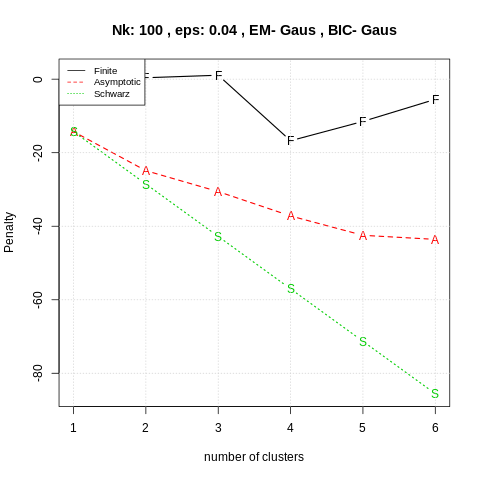

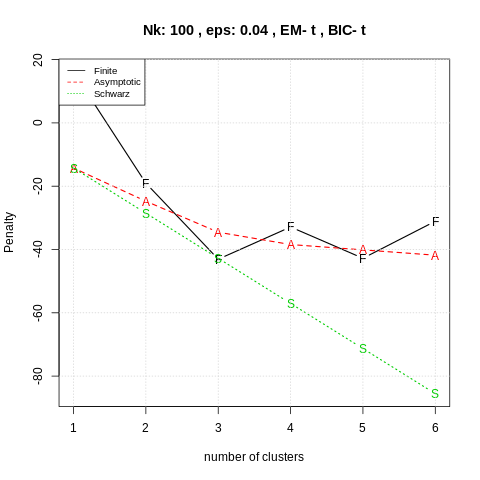

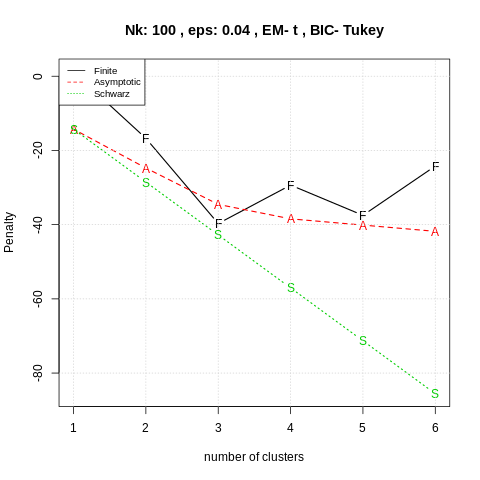

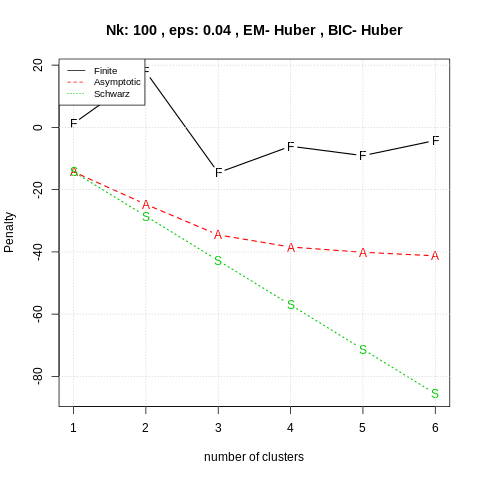

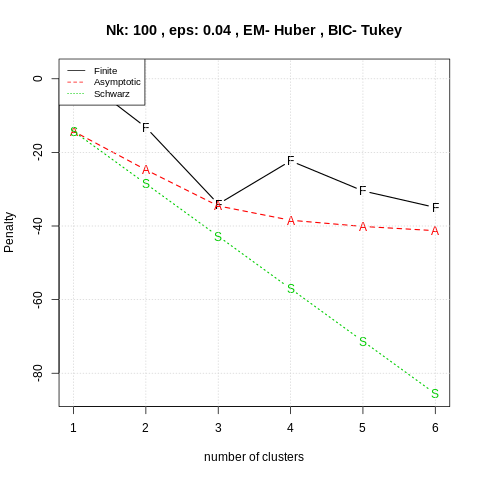

In [ ]:
%%R
# Penalty

for(ii_embic in 1:embic_iter){
graphics::matplot(pen_avg[,,ii_embic], lwd = 1.5, xlab = "number of clusters", ylab = "Penalty", pch=c("F", "A", "S"), type = 'b', col=1:3)
graphics::title(paste("Nk:",toString(N_k),", eps:", toString(epsilon),", EM-", g_names[em_bic[ii_embic,1]], ", BIC-", g_names[em_bic[ii_embic,2]]))


graphics::grid()
graphics::legend("topleft", legend=names, lty=1:3, col=1:3)

}

# SI Breakdown

In [ ]:
%%R
library(ICASSP20.T6.R)

# User Input
# Percentage of replacement outliers
epsilon <- seq(0, 0.35, 0.1)
# Number of data points per cluster
N_k <- 50
# Monte Carlo iterations
MC <- 10
# Select combinations of EM and BIC to be simulated
# 1: Gaussian, 2: t, 3: Huber, 4: Tukey
em_bic <- matrix(c(1,1, 2,2, 2,4, 3,3, 3,4),5, 2, byrow = TRUE)
# design parameter
nu <- 3 # t
qH <- 0.8 # Huber
cT <- 4.685 # Tukey

# Data Generation

embic_iter = nrow(em_bic)
eps_iter <- length(epsilon)
data <- array(0, c(N_k *3, 2, eps_iter, MC))

for(iEpsilon in 1:eps_iter){
  for(iMC in 1:MC){
    tmp <- ICASSP20.T6.R::data_31(N_k, epsilon[iEpsilon])
    data[,,iEpsilon, iMC] <- tmp$data
    labels_true <- tmp$labels
    r <- tmp$r
    N <- tmp$N
    K_true <- tmp$K_true
    mu_true <- tmp$mu_true
    S_true <- tmp$scatter_true
  }
}

L_max <- 2*K_true # Search range

# Model Definitions

cH <- sqrt(stats::qchisq(qH, r))
bH <- stats::pchisq(cH^2, r+2) + cH^2/r*(1-stats::pchisq(cH^2, r))
aH <- gamma(r/2)/pi^(r/2) / ( (2*bH)^(r/2)*(gamma(r/2) - pracma::incgam(r/2, cH^2/(2*bH))) + (2*bH*cH^2*exp(-cH^2/(2*bH)))/(cH^2 - bH * r))

g <- list(gaus = function(t) g_gaus(t, r),
        t = function(t) g_t(t, r, nu),
      huber = function(t) g_huber(t, r, list(cH, bH, aH)))

rho <- list(gaus = function(t) rho_gaus(t, r),
        t = function(t) rho_t(t, r, nu),
        huber = function(t) rho_huber(t, r, list(cH, bH, aH)),
        tukey = function(t) rho_tukey(t, r, cT)
        )

psi <- list(gaus = function(t) psi_gaus(t),
        t = function(t) psi_t(t, r, nu),
        huber = function(t) psi_huber(t, r, list(cH, bH)),
        tukey = function(t) psi_tukey(t, cT)
        )

eta <- list(gaus = function(t) eta_gaus(t),
        t = function(t) eta_t(t, r, nu),
        huber = function(t) eta_huber(t, r, list(cH, bH)),
        tukey = function(t) eta_tukey(t, cT)
        )

bic_final <- array(0, c(MC, eps_iter, L_max, 3, embic_iter))
like_final <- array(0, c(MC, eps_iter, L_max, 3, embic_iter))
pen_final <- array(0, c(MC, eps_iter, L_max, 3, embic_iter))

# Cluster Enumeration

for(iEpsilon in 1:eps_iter){
  for(iMC in 1:MC){
    bic <- array(0, c(L_max, 3, embic_iter))
    pen <- array(0, c(L_max, 3, embic_iter))
    like <- array(0, c(L_max, 3, embic_iter))
    for(iEmBic in 1:embic_iter){
      for(ll in 1:L_max){
        # EM
        tmp <- EM_RES(data[,,iEpsilon, iMC], ll, g[[em_bic[iEmBic, 1]]], psi[[em_bic[iEmBic, 1]]])
        mu_est <- tmp$mu_hat
        S_est <- tmp$S_hat
        t <- tmp$t
        R <- tmp$R
        mem <- (R == apply(R, 1, max))
        
        # BIC
        bicf <- BIC_F(data[,,iEpsilon,iMC], S_est, mu_est, t, mem, rho[[em_bic[iEmBic, 2]]], psi[[em_bic[iEmBic, 2]]], eta[[em_bic[iEmBic, 2]]])
        bica <- BIC_A(S_est, t, mem, rho[[em_bic[iEmBic, 2]]], psi[[em_bic[iEmBic, 2]]], eta[[em_bic[iEmBic, 2]]])
        bics <- BIC_S(S_est, t, mem , rho[[em_bic[iEmBic, 2]]])
        
        bic[ll,,iEmBic] <- c(bicf$bic, bica$bic, bics$bic)
        like[ll,,iEmBic] <- c(bicf$like, bica$like, bics$like)
        pen[ll,,iEmBic] <- c(bicf$pen, bica$pen, bics$pen)
      }
    }
    bic_final[iMC, iEpsilon,,,] <- bic
    like_final[iMC, iEpsilon,,,] <- like
    pen_final[iMC, iEpsilon,,,] <- pen
  }
  print(epsilon[iEpsilon])
}

# Evaluation
p_under <- array(0, c(dim(bic_final)[4], eps_iter, embic_iter))
p_det <- array(0, c(dim(bic_final)[4], eps_iter, embic_iter))
p_over <- array(0, c(dim(bic_final)[4], eps_iter, embic_iter))

for(iEmBic in 1:embic_iter){
  for(iEpsilon in 1:eps_iter){
    for(k in 1:dim(bic_final)[4]){
      BICmax <- aperm(bic_final[,iEpsilon,,k,iEmBic, drop = FALSE]
                       , c(1, 3, 4, 2, 5)) == apply(aperm(bic_final[,iEpsilon,,k,iEmBic, drop = FALSE], c(1,3,4,2,5)), 1, max )
      
      K_true_det <- pracma::repmat(c(K_true == 1:K_true, numeric(L_max-K_true) ), MC, 1) == 1
      
      K_true_under <- pracma::repmat(c(!(K_true == 1:(K_true-1)), numeric(L_max-K_true+1) ), MC, 1) == 1
      
      p_under[k, iEpsilon, iEmBic] <- sum(BICmax[K_true_under])/MC
      p_det[k, iEpsilon, iEmBic] <- sum(BICmax[K_true_det])/MC
      p_over[k, iEpsilon, iEmBic] <- 1 - p_det[k, iEpsilon, iEmBic] - p_under[k, iEpsilon, iEmBic]
    }
  }
}

[1] 0
[1] 0.1
[1] 0.2
[1] 0.3


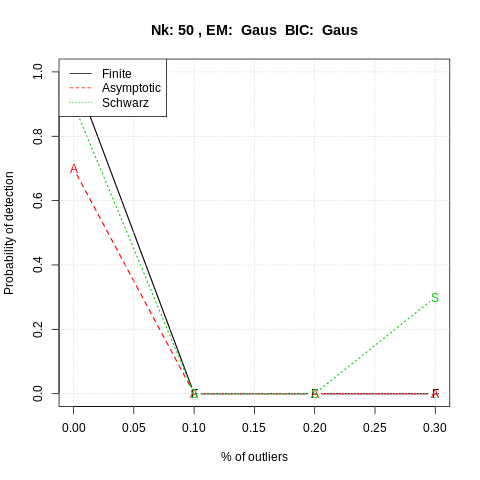

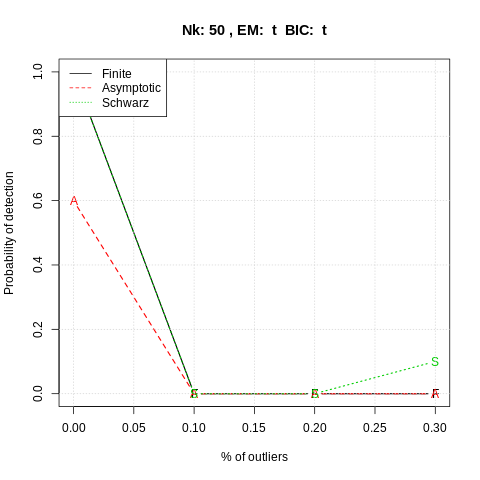

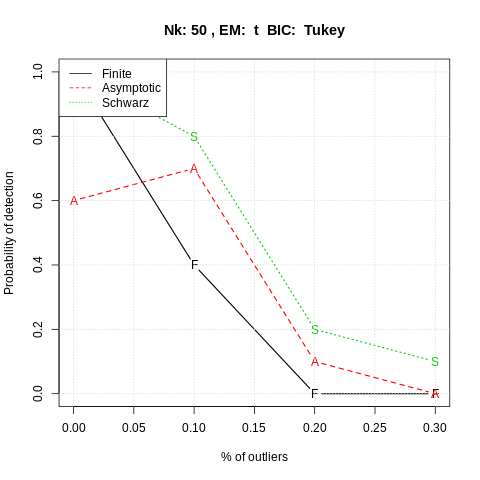

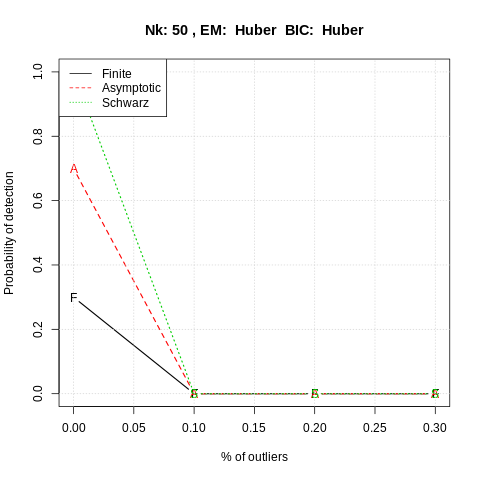

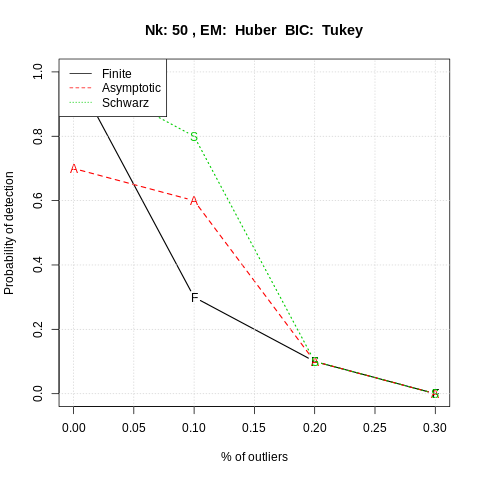

In [ ]:
%%R
marker = c('o','s','d','*','x','^','v','>','<','p','h', '+', 'o')
names = c("Finite", "Asymptotic", "Schwarz")
g_names = c("Gaus", "t", "Huber", "Tukey")

for(iEmBic in 1:embic_iter){
graphics::matplot(epsilon, t(p_det[,,iEmBic]), lwd = 1.5, xlab = "% of outliers", ylab = "Probability of detection", pch=c("F", "A", "S"), type = 'b', col=1:3)
graphics::title(paste("Nk:",toString(N_k),", EM: ", g_names[em_bic[iEmBic,1]]," BIC: ", g_names[em_bic[iEmBic,2]]))


graphics::grid()
graphics::legend("topleft", legend=names, lty=1:3, col=1:3)

}

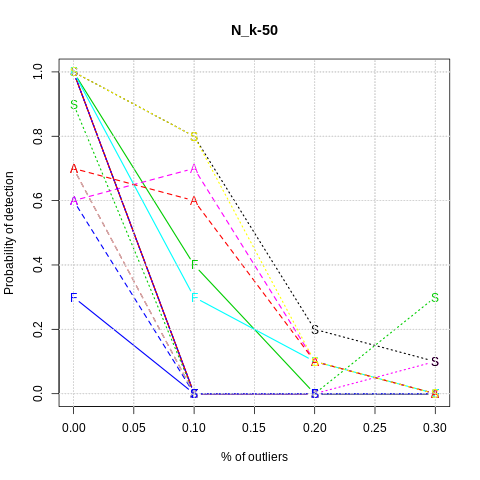

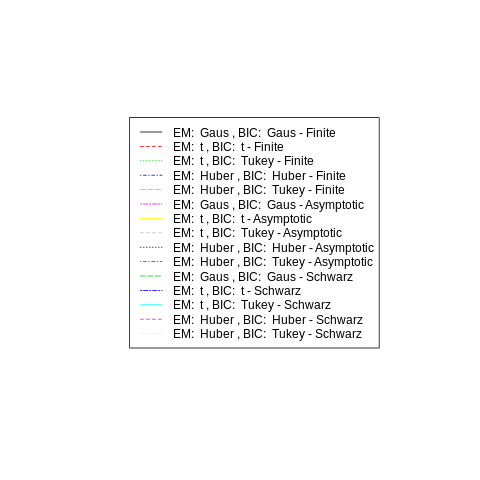

In [ ]:
%%R
names_all <- matrix("", embic_iter, 3)

graphics::matplot(epsilon, t(p_det[,,1]), lwd = 1.5, xlab = "% of outliers", ylab = "Probability of detection", pch=c("F", "A", "S"), type = 'b', col=1:3)
names_all[1,] <- paste("EM: "
                           ,g_names[em_bic[1,1]]
                           , ", BIC: "
                           , g_names[em_bic[1,2]]
                           , "-"
                             ,names)  
for(iEmBic in 2:embic_iter){
  names_all[iEmBic,] <- paste("EM: "
                             ,g_names[em_bic[iEmBic,1]]
                             , ", BIC: "
                             , g_names[em_bic[iEmBic,2]]
                             , "-"
                             ,names)

  graphics::matlines(epsilon, t(p_det[,,iEmBic]), lwd = 1.5, xlab = "% of outliers", ylab = "Probability of detection", pch=c("F", "A", "S"), type = 'b', col=(1:3)*iEmBic)
  
  graphics::grid()

  }
graphics::title("N_k-50")
graphics::plot.new()
graphics::legend("center", legend=names_all, lty=1:15, col=1:15)


In [ ]:
%%R
names_3 <- paste("EM: ", g_names[em_bic[,1]], " , BIC: ", g_names[em_bic[,2]])


for(iEmBic in 1:3){
graphics::matplot(epsilon,
                  p_det[iEmBic,,],
                  lwd=1.5,
                  xlab = "% of outliers",
                  ylab = "Probability of detection",
                  type="b")

graphics::legend("topright", names_3, lty=1:5, col=1:5)
graphics::title(paste("N_k-", toString(N_k), ", BIC-", names[iEmBic]))

}

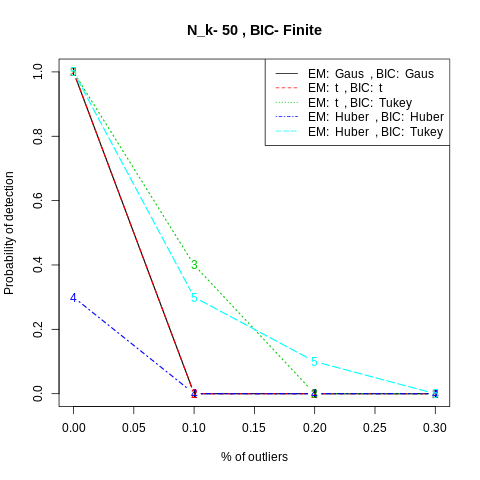

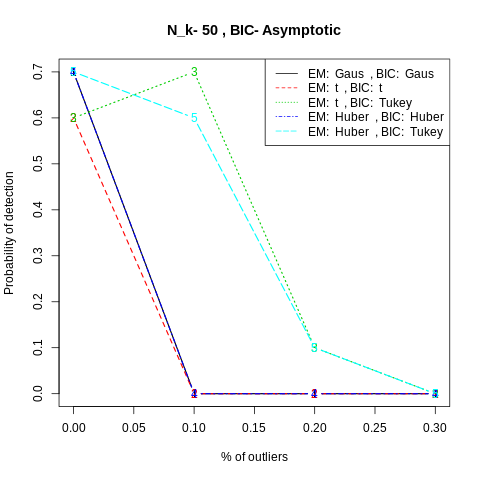

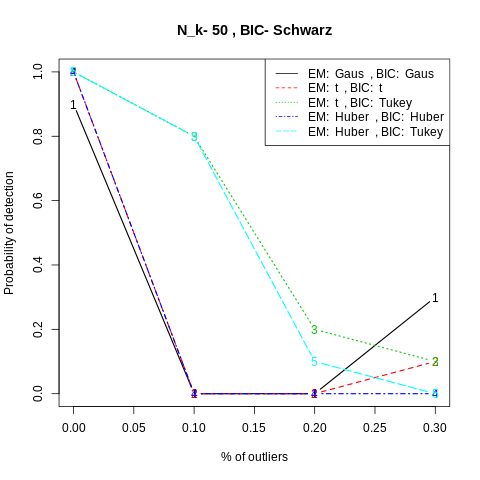

# SI EM

In [ ]:
%%R
library(zeallot)
# User Input

epsilon <- 0.15 # Percentage of replacement outliers
N_k <- 50 # Number of samples per cluster
nu <- 3 # DoF for t distribution
qH <- .8 # Tuning parameter for Huber distribution

# Create data
c(data, labels, r, N, K_true, mu_true, S_true) %<-% data_31(N_k, epsilon)

cH <- sqrt(stats::qchisq(qH, r))
bH <- stats::pchisq(cH^2, r+2) + cH^2/r*(1-stats::pchisq(cH^2, r))
aH <- gamma(r/2)/pi^(r/2) / ( (2*bH)^(r/2)*(gamma(r/2) - pracma::incgam(r/2, cH^2/(2*bH))) + (2*bH*cH^2*exp(-cH^2/(2*bH)))/(cH^2 - bH * r))

g <- list(gaus = function(t) g_gaus(t, r),
        t = function(t) g_t(t, r, nu),
      huber = function(t) g_huber(t, r, list(cH, bH, aH)))

psi <- list(gaus = function(t) psi_gaus(t),
        t = function(t) psi_t(t, r, nu),
        huber = function(t) psi_huber(t, r, list(cH, bH)),
        tukey = function(t) psi_tukey(t, cT)
        )

x <- seq(-20,20,.1)
y <- seq(-20,20,.1)
grd <- pracma::meshgrid(x, y)
g_names <- c("Gaussian", "t", "Huber")

In [ ]:
%%R
plot_scatter(cbind(labels, data), K_true, r)

for(m in 1:K_true){
  Z <- Rfast::dmvnorm(cbind(c(grd$X), c(grd$Y)), mu_true[,m], S_true[,,m])
  Z <- pracma::Reshape(Z, dim(grd$X)[1], dim(grd$X)[2])
  graphics::contour(x, y, t(Z), col = grDevices::rainbow(12), add = TRUE)
}

graphics::title("Model True", xlab = "Feature 1", ylab = "Feature 2")


#EM
for(i in 1:3){ 
  c(mu_est, S_est, t, R) %<-% EM_RES(data, K_true, g[[i]], psi[[i]])
  
  plot_scatter(cbind(labels, data), K_true, r)
  for(m in 1:K_true){
    Z <- Rfast::dmvnorm(cbind(c(grd$X), c(grd$Y)), mu_est[,m], S_est[,,m])
    Z <- pracma::Reshape(Z, dim(grd$X)[1], dim(grd$X)[2])
    graphics::contour(x, y, t(Z), col = grDevices::rainbow(12), add = TRUE)
  }
  graphics::title(paste("Model ", g_names[[i]]), xlab = "Feature 1", ylab = "Feature 2")
}

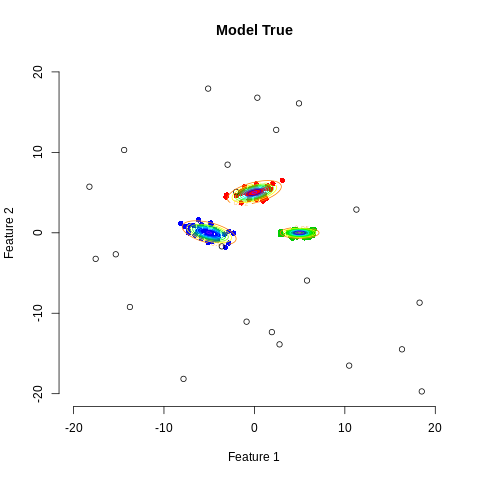

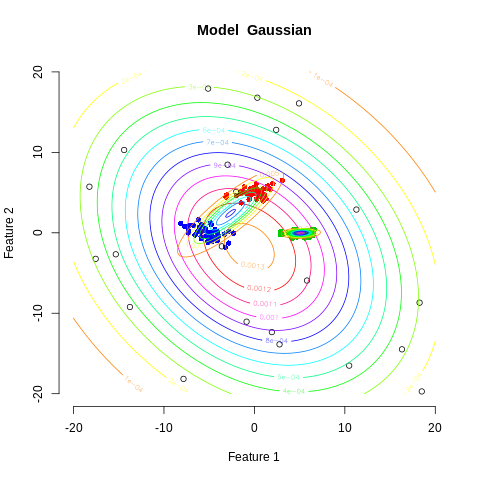

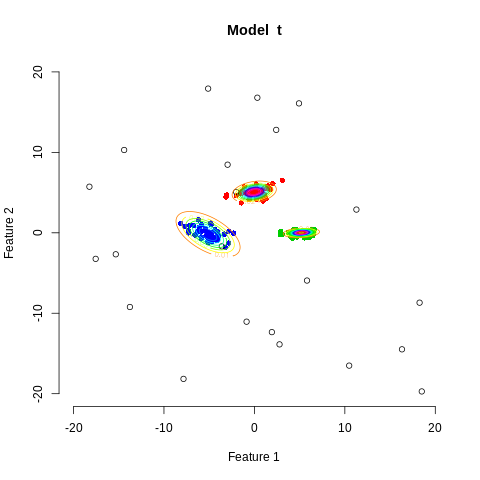

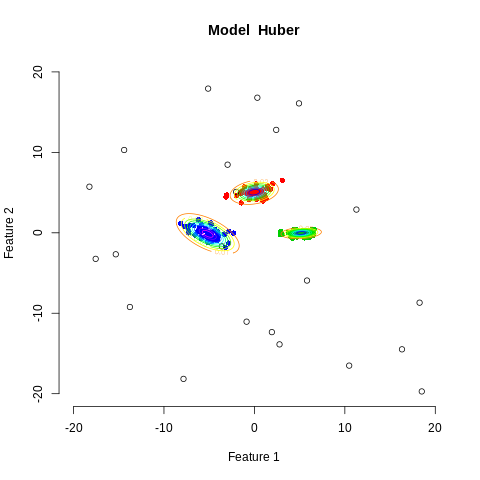

# SI Sensitivity

In [ ]:
%%R
# Warning: Takes ca. 1 hour
library(ICASSP20.T6.R)
library(zeallot)
library(parallel)
library(doParallel)
library(foreach)

# User Data
MC <- 5 # number of Monte Carlo iterations
epsilon <- 0.04 # percantage of replacement outliers
N_k <- 50 # Number of samples per cluster

em_bic <- matrix(c(1,1, 2,2, 2,4, 3,3, 3,4),5, 2, byrow = TRUE)
embic_iter = nrow(em_bic)
nu <- 3 # t
qH <- 0.8 # Huber
cT <- 4.685 # Tukey

out_range <- matrix(c(-20, -20, 20, 20), 2, 2) # range of outliers
step_eps <- 10 # steps between outliers

# Data Generation
x <- seq(out_range[1, 1], out_range[1, 2], step_eps)
y <- seq(out_range[2, 1], out_range[2, 2], step_eps)
c(X, Y) %<-% pracma::meshgrid(x, y)
eps_iter <- length(x)^2

data <- array(0, c(N_k*3,2,eps_iter,MC))
for(ii_eps in 1:eps_iter){
  for(ii_mc in 1:MC){

    c(data[,,ii_eps, ii_mc], labels, r, N, K_true, mu_true, S_true) %<-% data_31(N_k, 0)
    N_repl <- 1
    index_repl <- pracma::randperm(N, N_repl)
    data[index_repl, , ii_eps, ii_mc] <- c(X[ii_eps], Y[ii_eps])
  }
}

L_max <- 2*K_true # search range

# Huber Parameters
cH <- sqrt(stats::qchisq(qH, r))
bH <- stats::pchisq(cH^2, r+2) + cH^2/r*(1-stats::pchisq(cH^2, r))
aH <- gamma(r/2)/pi^(r/2) / ( (2*bH)^(r/2)*(gamma(r/2) - pracma::incgam(r/2, cH^2/(2*bH))) + (2*bH*cH^2*exp(-cH^2/(2*bH)))/(cH^2 - bH * r))

g <- list(gaus = function(t) g_gaus(t, r),
        t = function(t) g_t(t, r, nu),
        huber = function(t) g_huber(t, r, list(cH, bH, aH)))

rho <- list(gaus = function(t) rho_gaus(t, r),
        t = function(t) rho_t(t, r, nu),
        huber = function(t) rho_huber(t, r, list(cH, bH, aH)),
        tukey = function(t) rho_tukey(t, r, cT)
        )

psi <- list(gaus = function(t) psi_gaus(t),
        t = function(t) psi_t(t, r, nu),
        huber = function(t) psi_huber(t, r, list(cH, bH)),
        tukey = function(t) psi_tukey(t, cT)
        )

eta <- list(gaus = function(t) eta_gaus(t),
        t = function(t) eta_t(t, r, nu),
        huber = function(t) eta_huber(t, r, list(cH, bH)),
        tukey = function(t) eta_tukey(t, cT)
        )


bic_final <- array(0, c(MC, eps_iter, L_max, 3, embic_iter))
like_final <- array(0, c(MC, eps_iter, L_max, 3, embic_iter))
pen_final <- array(0, c(MC, eps_iter, L_max, 3, embic_iter))

num_cl <- parallel::detectCores()
cl <- parallel::makeCluster(num_cl)


for(ii_eps in 1:eps_iter){
  # tmp: List(List(bic_1,...),...,List(bic_5,...))
  tmp <- foreach(iMC = 1:MC) %dopar% {
    bic <- array(0, c(L_max, 3, embic_iter))
    like <- array(0, c(L_max, 3, embic_iter))
    pen <- array(0, c(L_max, 3, embic_iter))
    for(iEmBic in 1:embic_iter){
        print(c(ii_eps,iMC, iEmBic))
        for(ll in 1:L_max){
          c(mu_est, S_est, t, R) %<-% EM_RES(data[,,ii_eps, iMC], ll, g[[em_bic[iEmBic, 1]]], psi[[em_bic[iEmBic, 1]]])
          
          mem <- (R == apply(R, 1, max))
          
          c(bic[ll, 1, iEmBic], pen[ll, 1, iEmBic], like[ll, 1, iEmBic]) %<-% BIC_F(data[,,ii_eps,iMC], S_est, mu_est, t, mem, rho[[em_bic[iEmBic, 2]]], psi[[em_bic[iEmBic, 2]]], eta[[em_bic[iEmBic, 2]]])
          c(bic[ll, 2, iEmBic], pen[ll, 2, iEmBic], like[ll, 2, iEmBic]) %<-% BIC_A(S_est, t, mem, rho[[em_bic[iEmBic, 2]]], psi[[em_bic[iEmBic, 2]]], eta[[em_bic[iEmBic, 2]]])
          c(bic[ll, 3, iEmBic], pen[ll, 3, iEmBic], like[ll, 3, iEmBic]) %<-% BIC_S(S_est, t, mem , rho[[em_bic[iEmBic, 2]]])
          
        }
    }
    return(list(bic=bic, like=like, pen=pen)) 
  }
  for(i in 1:MC){
    bic_final[i, ii_eps,,,] <- tmp[[i]]$bic
    pen_final[i, ii_eps,,,] <- tmp[[i]]$pen
    like_final[i, ii_eps,,,] <- tmp[[i]]$like
  }
}  
parallel::stopCluster(cl)
# Evaluation

p_under <- array(0, c(dim(bic_final)[4], eps_iter, embic_iter))
p_det <- array(0, c(dim(bic_final)[4], eps_iter, embic_iter))
p_over <- array(0, c(dim(bic_final)[4], eps_iter, embic_iter))

K_true_det <- pracma::repmat(c(rep(K_true, K_true) == 1:K_true, numeric(L_max-K_true)), MC, 1) == 1

K_true_under <- pracma::repmat(c(!(rep(K_true, K_true-1) == 1:(K_true-1)), numeric(L_max-K_true+1) ), MC, 1) == 1

for(iEmBic in 1:embic_iter){
  for(iEpsilon in 1:eps_iter){
    for(k in 1:dim(bic_final)[4]){
      BICmax <- aperm(bic_final[,iEpsilon,,k,iEmBic, drop = FALSE]
                      , c(1, 3, 4, 2, 5)) == apply(
                          aperm(bic_final[,iEpsilon,,k ,iEmBic ,drop = FALSE]
                                , c(1,3,4,2,5)), 1, max )

      p_under[k, iEpsilon, iEmBic] <- sum(BICmax[K_true_under])/MC
      p_det[k, iEpsilon, iEmBic] <- sum(BICmax[K_true_det])/MC
      p_over[k, iEpsilon, iEmBic] <- 1 - p_det[k, iEpsilon, iEmBic] - p_under[k, iEpsilon, iEmBic]
    }
  }
}



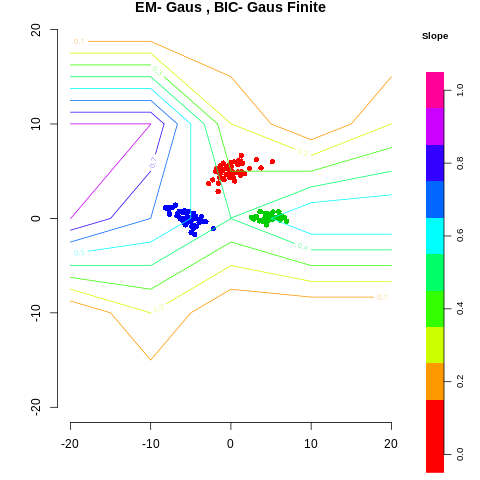

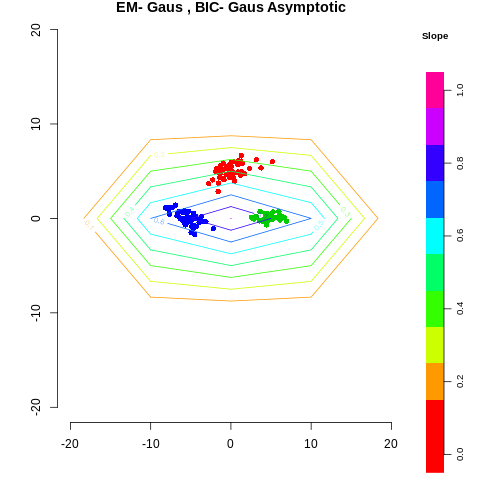

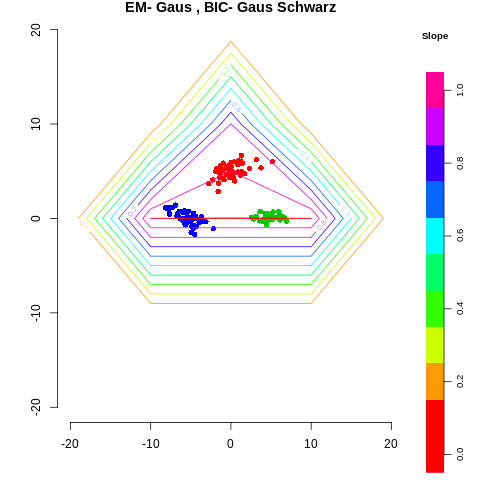

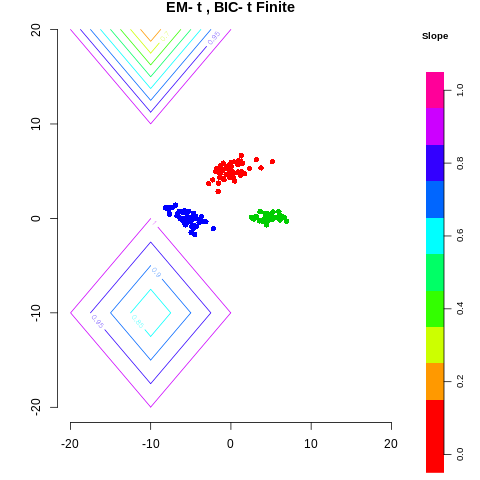

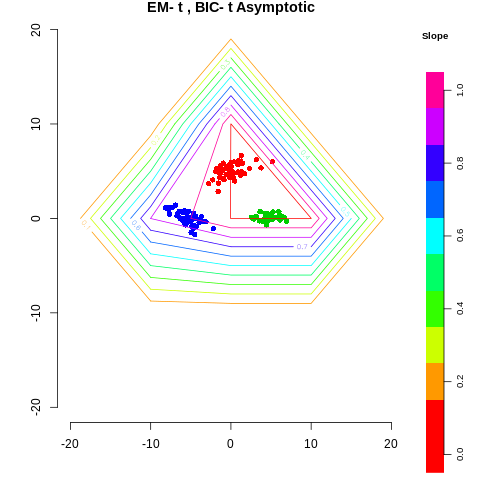

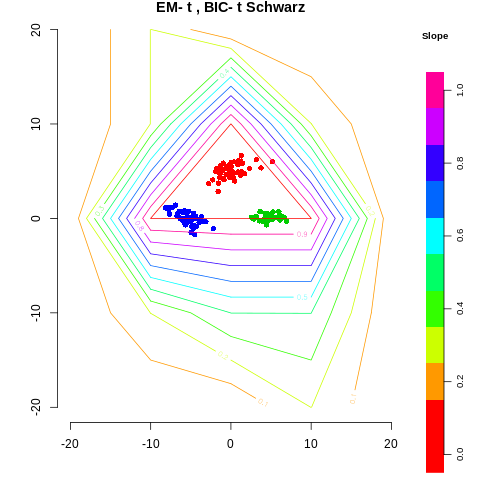

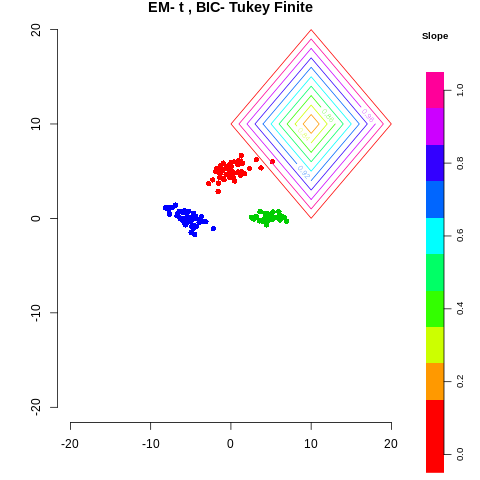

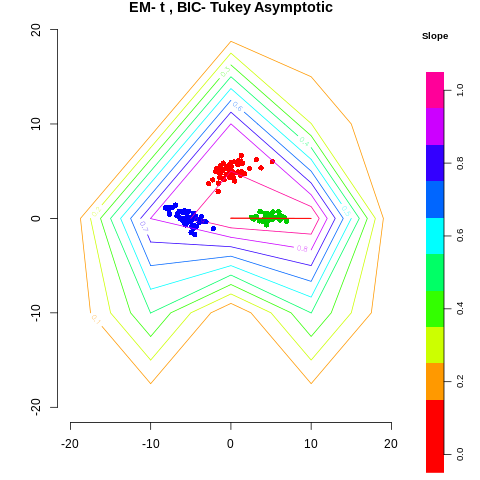

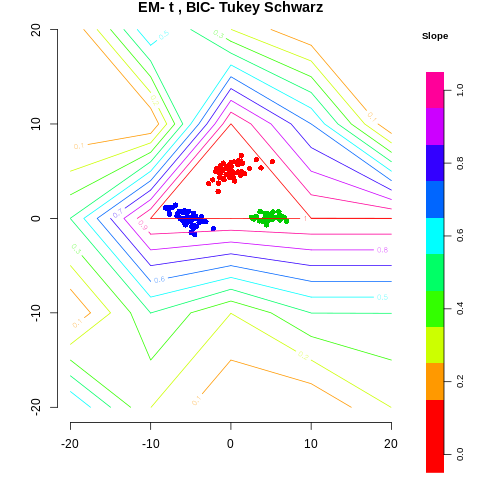

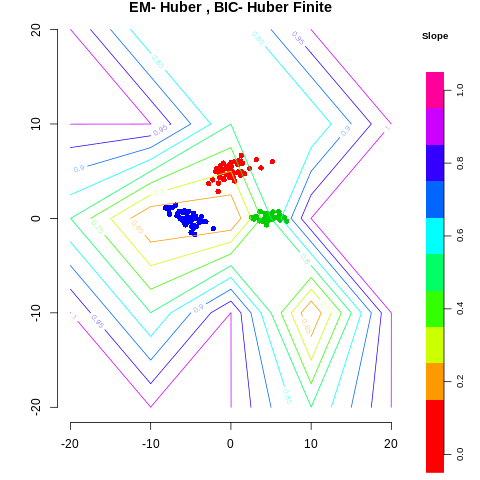

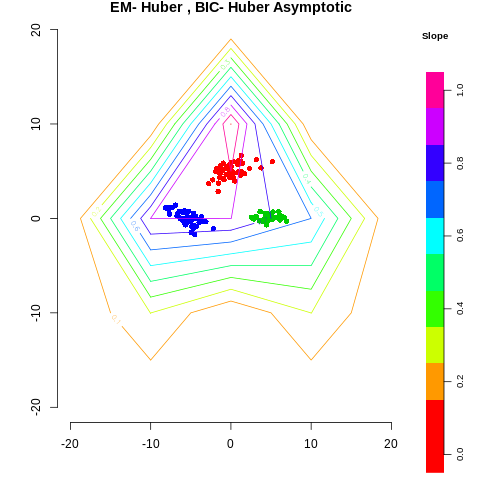

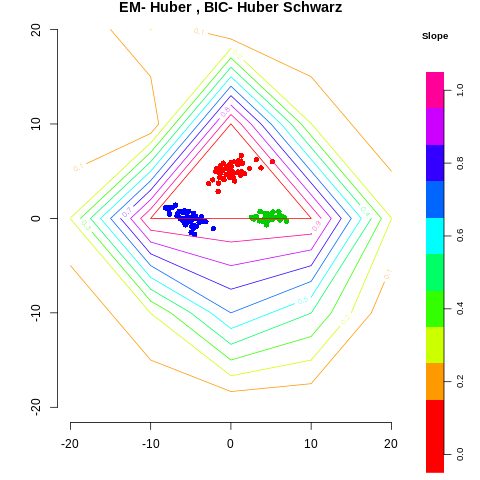

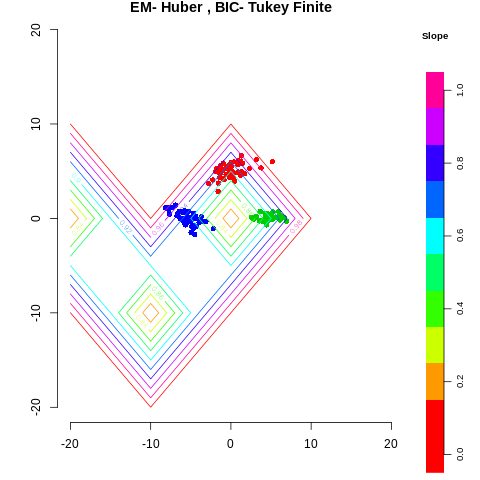

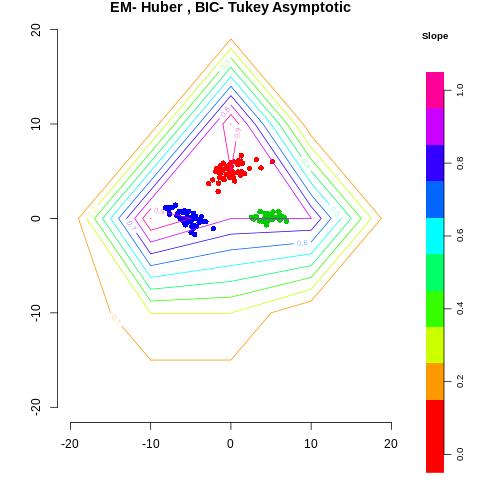

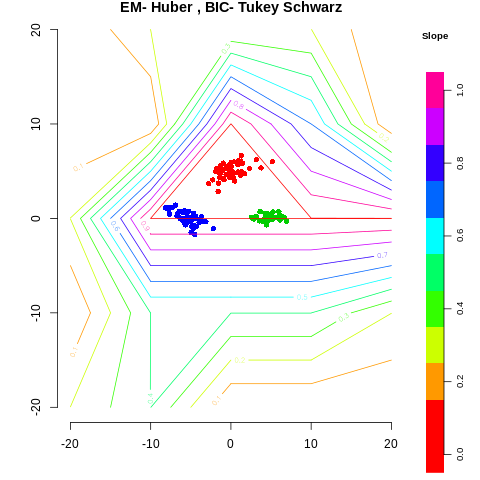

In [ ]:
%%R

#Plot  

names = c("Finite", "Asymptotic", "Schwarz")
g_names = c("Gaus", "t", "Huber", "Tukey")
p_det_2 <- aperm(p_det, c(2,1,3))
c(data2, labels, r, N, K_true, mu_true, S_true) %<-% data_31(N_k, 0)
for(iEmBic in 1: embic_iter){
  for(k_bic in 1:dim(bic_final)[4]){
    layout(t(1:2),widths=c(6,1))
    par(mar=c(4,4,1,0.5))

    plot_scatter(cbind(labels, data2), K_true, r)
    Z <- pracma::Reshape(p_det_2[, k_bic, iEmBic], dim(X)[1], dim(X)[2])
    graphics::contour(x, y, t(Z), add=TRUE, col = grDevices::rainbow(10))
    graphics::title(paste("EM-", g_names[[em_bic[iEmBic, 1]]], ", BIC-", g_names[[em_bic[iEmBic, 2]]], names[k_bic]))

    par(mar=c(.5,1,5,2.5))
    image(z=t(seq(0,1,.1)), col=grDevices::rainbow(10), axes=FALSE, main="Slope", cex.main=.8)
    axis(4,cex.axis=0.8,mgp=c(0,.5,0))
  }
}

# SI Simple

In [ ]:
%%R
# User Input
em_bic <- matrix(c(1,1, 2,2, 2,4, 3,3, 3,4),5, 2, byrow = TRUE)

nu <- 3 # t
qH <- 0.8 # Huber
cT <- 4.685 # Tukey

epsilon <- 0.15
N_k <- 250
c(data, labels, r, N, K_true, mu_true, S_true) %<-% data_31(N_k, epsilon)
L_max <- 2 * K_true

# Model Definitions
cH <- sqrt(stats::qchisq(qH, r))
bH <- stats::pchisq(cH^2, r+2) + cH^2/r*(1-stats::pchisq(cH^2, r))
aH <- gamma(r/2)/pi^(r/2) / ( (2*bH)^(r/2)*(gamma(r/2) - pracma::incgam(r/2, cH^2/(2*bH))) + (2*bH*cH^2*exp(-cH^2/(2*bH)))/(cH^2 - bH * r))

g <- list(gaus = function(t) g_gaus(t, r),
        t = function(t) g_t(t, r, nu),
      huber = function(t) g_huber(t, r, list(cH, bH, aH)))

rho <- list(gaus = function(t) rho_gaus(t, r),
        t = function(t) rho_t(t, r, nu),
        huber = function(t) rho_huber(t, r, list(cH, bH, aH)),
        tukey = function(t) rho_tukey(t, r, cT)
        )

psi <- list(gaus = function(t) psi_gaus(t),
        t = function(t) psi_t(t, r, nu),
        huber = function(t) psi_huber(t, r, list(cH, bH)),
        tukey = function(t) psi_tukey(t, cT)
        )

eta <- list(gaus = function(t) eta_gaus(t),
        t = function(t) eta_t(t, r, nu),
        huber = function(t) eta_huber(t, r, list(cH, bH)),
        tukey = function(t) eta_tukey(t, cT)
        )

embic_iter <- dim(em_bic)[1]
S_est <- matrix(list(), L_max, embic_iter)
mu_est <- matrix(list(), L_max, embic_iter)

bic <- array(0, c(L_max, 3, embic_iter))
pen <- array(0, c(L_max, 3, embic_iter))
like <- array(0, c(L_max, 3, embic_iter))

for(ii_embic in 1:embic_iter){
  for(ll in 1:L_max){
    # EM
    c(mu_est[[ll, ii_embic]], S_est[[ll, ii_embic]], t, R) %<-% EM_RES(data, ll, g[[em_bic[ii_embic, 1]]]
                                                                       , psi[[em_bic[ii_embic, 1]]])
    
    mem <- R == apply(R, 1, max)
    
    c(bic[ll, 1, ii_embic], like[ll, 1, ii_embic], pen[ll, 1, ii_embic]) %<-% BIC_F(data
                                                                                    , S_est[[ll, ii_embic]]
                                                                                    , mu_est[[ll, ii_embic]]
                                                                                    , t
                                                                                    , mem
                                                                                    , rho[[em_bic[ii_embic, 2]]]
                                                                                    , psi[[em_bic[ii_embic, 2]]]
                                                                                    , eta[[em_bic[ii_embic, 2]]])
    
    c(bic[ll, 2, ii_embic], like[ll, 2, ii_embic], pen[ll, 2, ii_embic]) %<-% BIC_A(S_est[[ll, ii_embic]]
                                                                                    , t
                                                                                    , mem
                                                                                    , rho[[em_bic[ii_embic, 2]]]
                                                                                    , psi[[em_bic[ii_embic, 2]]]
                                                                                    , eta[[em_bic[ii_embic, 2]]] 
                                                                                    )
    
    c(bic[ll, 3, ii_embic], like[ll, 3, ii_embic], pen[ll, 3, ii_embic]) %<-% BIC_S(S_est[[ll, ii_embic]]
                                                                                    , t
                                                                                    , mem
                                                                                    , rho[[em_bic[ii_embic, 2]]]
                                                                                    )
  }
}

x <- seq(-20, 20, .1)
y <- seq(-20, 20, .1)
c(X, Y) %<-% pracma::meshgrid(x, y)

names = c("Finite", "Asymptotic", "Schwarz")
g_names = c("Gaus", "t", "Huber", "Tukey")

for(ii_embic in 1:embic_iter){
    graphics::par(mfrow=c(1, 2))
    plot_scatter(cbind(labels, data), K_true, r)
    
    for(m in 1:K_true){
      Z <- Rfast::dmvnorm(cbind(c(X), c(Y)), mu_est[[ K_true, ii_embic]][, m], S_est[[K_true, ii_embic]][,,m])
      Z <- pracma::Reshape(Z, dim(X)[1], dim(X)[2])
      graphics::contour(x, y, t(Z), col = grDevices::rainbow(12), add = TRUE)
    }
    
    graphics::title(main = paste("EM: ", g_names[em_bic[ii_embic, 1]], " at K = ", toString(K_true))
                    , xlab = "Feature 1"
                    , ylab = "Feature 2")
    
    graphics::matplot(bic[,,ii_embic], xlab = "number of clusters", ylab = paste("BIC: ", g_names[[em_bic[ii_embic,2]]]), pch=c("F", "A", "S"), type = 'b')
    graphics::grid()
    graphics::legend("topleft", legend = names, lty=1:3, col=1:3)
    graphics::title(paste("Nk: ", toString(N_k), ", eps: ", toString(epsilon), ", EM-", g_names[[em_bic[ii_embic,1]]]))
}


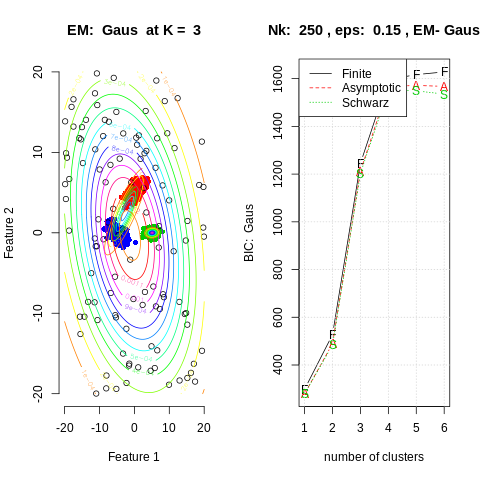

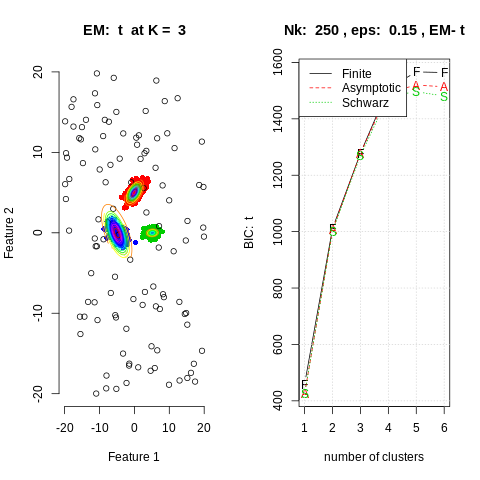

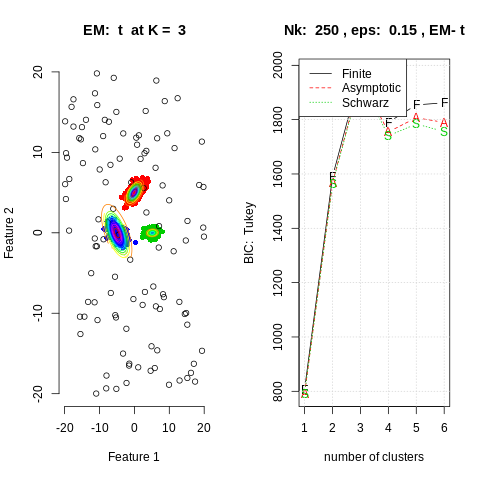

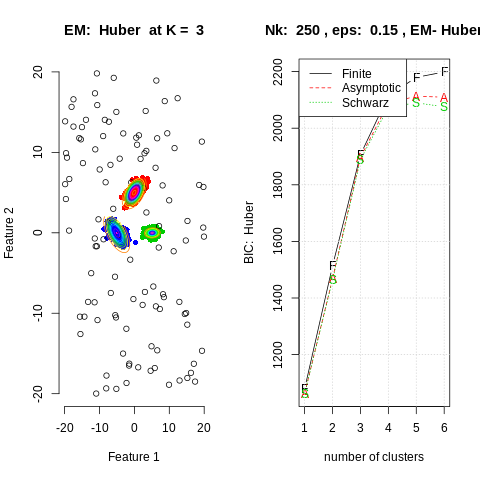

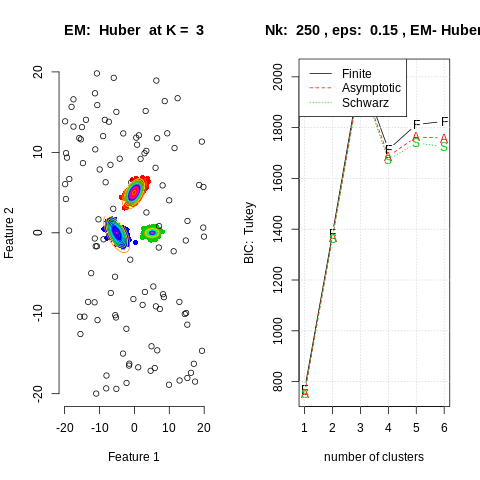